In [5]:
# import required library
if (!require(dummies)) {
    install.packages("dummies")
}
if (!require(DAAG)) {
    install.packages("DAAG")
}
library(dummies)  # dummy variable
library(moments)  # skewness
library(corrplot)  # corrplot
library(DAAG)  # cross-validation

In [6]:
# load the data set
train = read.csv('./train.csv')
test = read.csv('./test.csv')

# combine into one data frame
data = rbind(train[, -81], test)

In [18]:
# compute the number of missing values in each column
#num.NA = colSums(apply(data[, -1], 2, is.na))
#data.type = sapply(data[, names(which(num.NA != 0))], class)

# drop column of "LotFrontage", "Alley", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"
drop.names = c("LotFrontage", "Alley", "FireplaceQu", "PoolQC", "Fence", "MiscFeature")
data = data[ , !(names(data) %in% drop.names)]

# find all categorical and numerical variables
data.type = sapply(data[ , -1], class)
categorical.var = names(data)[which(c(NA, data.type, NA) == 'factor')]
numerical.var = names(data)[which(c(NA, data.type, NA) == 'integer')]

# create new feature named "NA" for categorical variables
for (i in categorical.var) {
    data[, i] = addNA(data[, i])
}

# create new feature using the median value for numerical variables
numerical.missing.var = c('MasVnrArea', 'GarageYrBlt')
for (i in numerical.missing.var) {
    na.id = is.na(data[, i])
    tmp.median = median(train[, i], na.rm=TRUE)
    data[which(na.id), i] = tmp.median
}

In [19]:
# transform numerical feature whose skewness is larger than 0.75
skewed.features = sapply(data[, numerical.var], skewness)
skewed.features = numerical.var[which(skewed.features > 0.75)]
for (i in skewed.features) {
    data[, i] = log(data[, i] + 1)
}

# directly transform "Street", "Utilities" and "CentralAir" into 0-1 values
data[, 'Street'] = as.numeric(data[, 'Street']) - 1
data[, 'Utilities'] = as.numeric(data[, 'Utilities']) - 1
data[, 'CentralAir'] = as.numeric(data[, 'CentralAir']) - 1

# find new categorical variable to create dummy variables
categorical.var = names(which(sapply(data[, categorical.var], function(x) length(unique(x))) > 2))
dummy.var = data.frame(dummy.data.frame(data[, categorical.var], sep='.'))
data = cbind(data, dummy.var)

# drop original categorical variables
data = data[ , !(names(data) %in% categorical.var)]

data.train = data[1:nrow(train), ]
data.test = data[(nrow(train) + 1):nrow(data), ]

data.train['SalePrice'] = train$SalePrice

# transform the response variable into log scale
data.train$SalePrice = log(data.train$SalePrice + 1)

# Correlation

In [3]:
correlations = cor(data.train[, c(numerical.var, 'SalePrice')])  # correlation matrix
# for those relatively large correlations (> 0.3)
row_indic = apply(correlations, 1, function(x) sum(abs(x) > 0.3) > 1)
correlations = correlations[row_indic, row_indic]
#corrplot(correlations, method = "square")
    
# record those with very large correlation (> 0.6)
highCor = which(abs(correlations[, ncol(correlations)]) > 0.6)
highCor = highCor[-length(highCor)]

Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”

Warning message in cv.lm(data.train[, c(names(highCor), "SalePrice")], SalePrice ~ :
“

 As there is >1 explanatory variable, cross-validation
 predicted values for a fold are not a linear function
 of corresponding overall predicted values.  Lines that
 are shown for the different folds are approximate
”

[1] 101.3985

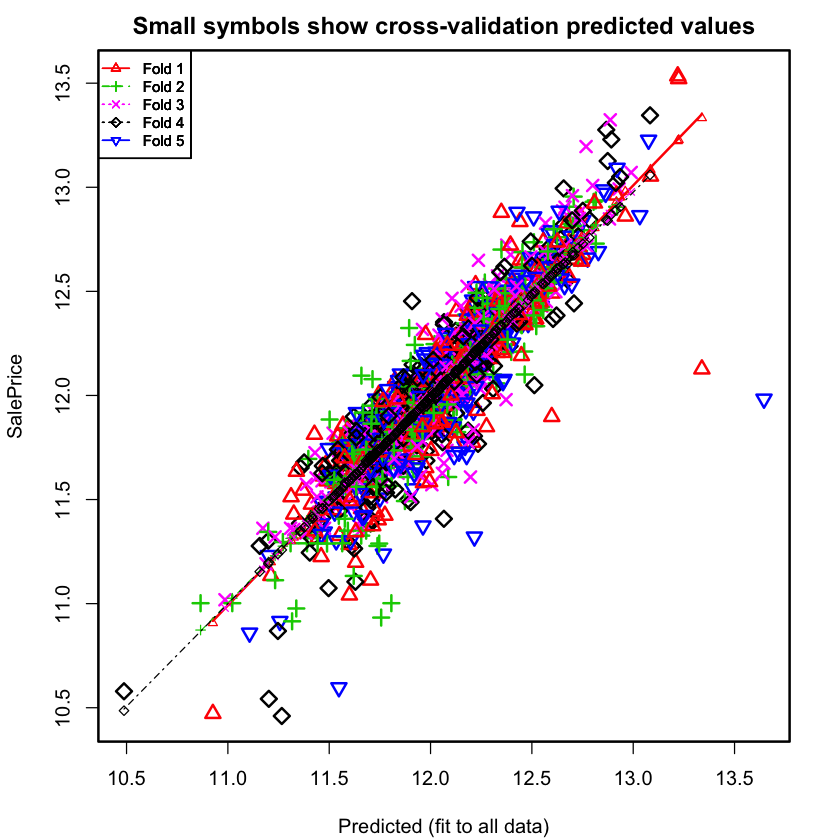

In [4]:
model.cv = cv.lm(data.train[, c(names(highCor), 'SalePrice')], SalePrice ~ ., m=5, seed=29, printit=FALSE)
attr(model.cv, "ms")

In [5]:
model = lm(SalePrice ~ ., data = data.train[, c(names(highCor), 'SalePrice')])
predict.test.y = predict(model, newdata=data.test)
predict.test.y = exp(predict.test.y) - 1

In [6]:
submission = read.csv('./other/sample_submission.csv')
submission$SalePrice = predict.test.y
write.table(submission, './LS_model.csv', row.names = FALSE, sep = ',')

# With all variables

Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(subs.lm, newdata = data[rows.out, ]):
“prediction from a rank-deficient fit may be misleading”

Warning message in cv.lm(data.train[, -1], SalePrice ~ ., m = 5, seed = 29, printit = FALSE):
“

 As there is >1 explanatory variable, cross-validation
 predicted values for a fold are not a linear function
 of corresponding overall predicted values.  Lines that
 are shown for the different folds are approximate
”

[1] 57.75322

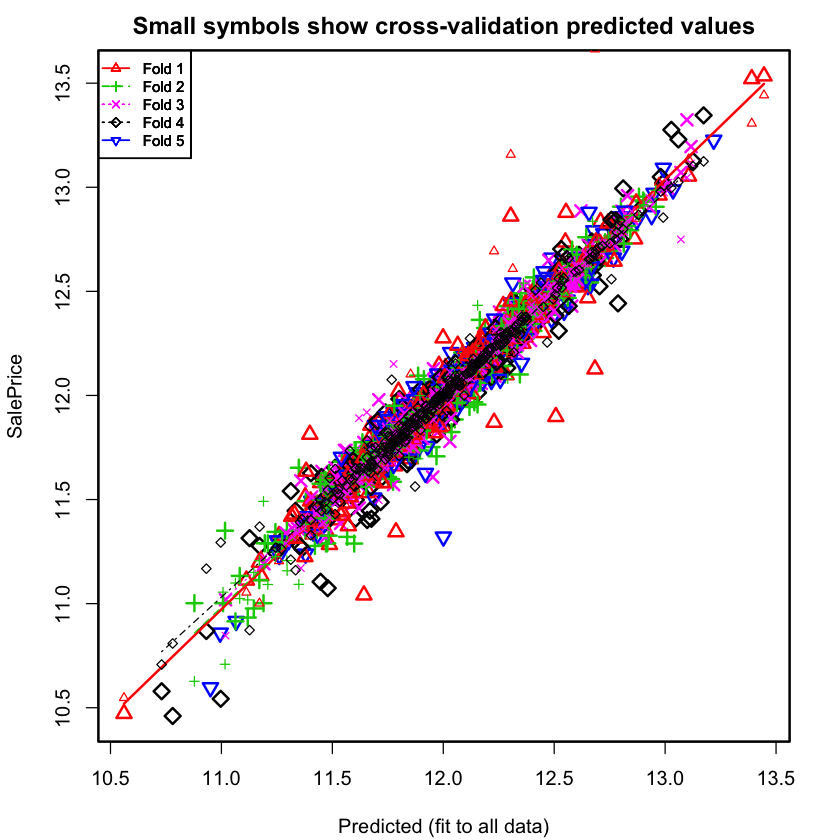

In [3]:
# build a simple linear regression model for cross-validation
model.cv = cv.lm(data.train[, -1], SalePrice ~ ., m=5, seed=29, printit=FALSE)
attr(model.cv, "ms")

Warning message in predict.lm(model, data.train):
“prediction from a rank-deficient fit may be misleading”

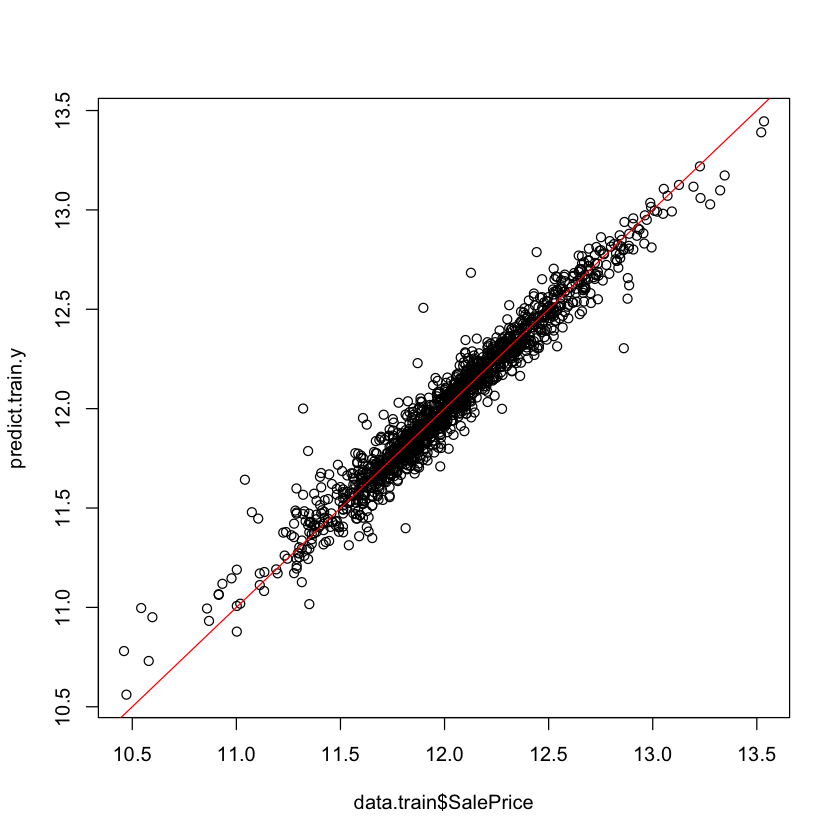

In [4]:
# build a simple LS model
model = lm(SalePrice ~ ., data=data.train[, -1])
predict.train.y = predict(model, data.train)
plot(data.train$SalePrice, predict.train.y)
lines(x = c(10,14), y = c(10,14), col='red')

In [5]:
# predict on the test data
predict.test.y = predict(model, data.test)
predict.test.y = exp(predict.test.y) - 1

Warning message in predict.lm(model, data.test):
“prediction from a rank-deficient fit may be misleading”

In [6]:
submission = read.csv('./other/sample_submission.csv')
submission$SalePrice = predict.test.y
write.table(submission, './LS_model.csv', row.names = FALSE, sep = ',')

# With only numerical variables

In [7]:
model = lm(SalePrice ~ ., data=data.train[, c(numerical.var, 'SalePrice')])
predict.test.y = predict(model, data.test)
predict.test.y = exp(predict.test.y) - 1

Warning message in predict.lm(model, data.test):
“prediction from a rank-deficient fit may be misleading”

In [8]:
submission = read.csv('./other/sample_submission.csv')
submission$SalePrice = predict.test.y
write.table(submission, './LS_model.csv', row.names = FALSE, sep = ',')